In [1]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, softmax, sigmoid, swish
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB7
from tensorflow.keras.preprocessing import image

2023-01-02 08:28:17.907590: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-02 08:28:22.754880: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-02 08:28:22.756545: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-02 08:28:22.763274: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-02 08:28:22.763311: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lnx00273.ad.liu.se
2023-01-02 08:28:22.763319: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lnx00273.ad.liu.se
2023-01-02 08:28:22.763391: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.60.11
2023-01-02 08:28:2

In [2]:
datagenerator_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=30,
    vertical_flip=False,
    #brightness_range=[0.90,1.25],
    fill_mode='nearest'
)

datagenerator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [3]:
# load and iterate training dataset
train_data = datagenerator_train.flow_from_directory('/local/data1/chash345/train', 
    class_mode='binary',
    target_size=(224, 224), 
    batch_size=32, 
    shuffle=False,
    color_mode='rgb')

# load and iterate validation dataset
val_data = datagenerator.flow_from_directory('/local/data1/chash345/valid', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32, 
    shuffle=False,
    color_mode='rgb')

# load and iterate test dataset
test_data = datagenerator.flow_from_directory('/local/data1/chash345/test', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=16, 
    shuffle=False,
    color_mode='rgb')

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


In [5]:
generated_image.shape

(32, 224, 224, 3)

In [17]:
pre_trained_model_efficientnet = EfficientNetB7(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet")

In [20]:
# Some weights in later layers are unfreezed
for layer in pre_trained_model_efficientnet.layers[:-5]:
    layer.trainable=False

tf.random.set_seed(10)

inputs = keras.Input(shape=(224,224,3))
#norm_layer = keras.layers.experimental.preprocessing.Normalization()
#mean = np.array([127.5]*3)
#var = mean ** 2
#x = norm_layer(inputs)
#norm_layer.set_weights([mean , var])

x = pre_trained_model_efficientnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128,activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)


# model = tf.keras.models.Sequential([
#     pre_trained_model_xception,
#     Flatten(),    
#     Dense(256,activation="swish"),
#     Dropout(0.4),
#     Dense(256,activation="swish"),
#     Dropout(0.4),
#     Dense(128, activation='swish'),  
#     Dense(1, activation='sigmoid')
# ])

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               327808    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129 

In [22]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight= 'balanced', y =train_data.classes, classes=np.unique(train_data.classes))
dict_weights = {0: weights[0], 1:weights[1]}
dict_weights

{0: 2.5, 1: 0.625}

In [13]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    class_weight=dict_weights  
)

Epoch 1/5
82/82 [==============================] - 450s 5s/step - loss: 0.7618 - binary_accuracy: 0.8000 - val_loss: 0.5458 - val_binary_accuracy: 0.7989
Epoch 2/5
82/82 [==============================] - 407s 5s/step - loss: 0.7428 - binary_accuracy: 0.8000 - val_loss: 0.5633 - val_binary_accuracy: 0.7989
Epoch 3/5
82/82 [==============================] - 407s 5s/step - loss: 0.7303 - binary_accuracy: 0.8000 - val_loss: 0.5738 - val_binary_accuracy: 0.7989
Epoch 4/5
82/82 [==============================] - 405s 5s/step - loss: 0.7204 - binary_accuracy: 0.8000 - val_loss: 0.5892 - val_binary_accuracy: 0.7989
Epoch 5/5
49/82 [================>.............] - ETA: 2:04 - loss: 0.6891 - binary_accuracy: 0.8135

In [11]:
# save the model weights after training
model = model.save('saved_model')

27/27 [==============================] - 168s 6s/step - loss: 0.5329 - binary_accuracy: 0.7998


[0.5329043865203857, 0.7997685074806213]

In [6]:
# Load the saved model anytime for inference
reconstructed_model = keras.models.load_model("saved_model")

2023-01-02 08:28:39.645773: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 08:28:39.646010: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [7]:
# Predict class probabilities from this reconstructed model
predicted_probs = reconstructed_model.predict(test_data)

2023-01-02 08:29:32.951870: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-02 08:29:32.952391: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492035000 Hz
2023-01-02 08:29:39.608418: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2023-01-02 08:29:39.723272: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2023-01-02 08:29:39.752715: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2023-01-02 08:29:39.858957: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2023-01-02 08:29:39.880134: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.


In [9]:
y_true = test_data.classes

In [11]:
predicted_classes = np.where(predicted_probs > 0.5, 1, 0)
y_pred = predicted_classes.reshape(1, len(test_data.classes))

In [12]:
confusion_matrix(y_true= y_true , y_pred=y_pred[0])

array([[113,  60],
       [ 74, 617]])

In [13]:
pd.DataFrame(classification_report(y_true, y_pred[0], output_dict=True)).T

,precision,recall,f1-score,support
0,0.604278,0.653179,0.627778,173.000000
1,0.911374,0.892909,0.902047,691.000000
accuracy,0.844907,0.844907,0.844907,0.844907
macro avg,0.757826,0.773044,0.764912,864.000000
weighted avg,0.849883,0.844907,0.847129,864.000000


In [14]:
# %%
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc

# %%
fpr, tpr, thresholds = roc_curve(test_data.classes, predicted_probs )

In [15]:
# %%
roc_auc_score(test_data.classes, predicted_probs )


0.8630743749111198

In [16]:
# %%
roc_auc_score(test_data.classes, predicted_probs )

0.8630743749111198

In [17]:
roc_auc = auc(fpr, tpr)

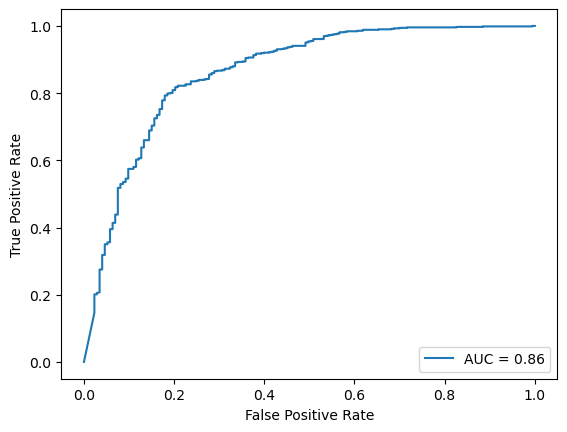

In [18]:
display = RocCurveDisplay(fpr=fpr,tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()